# MFBO Result Analysis

This notebook reproduces the analysis previously implemented in `analysis.py`.
Run the cells top-to-bottom to load `results/results.csv`, decode the tuning parameters, and generate the SSE vs SSdU and runtime plots.


In [1]:
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display

from matlab_interface import read_results

DEFAULT_PLOT_PATH = Path("results") / "sse_vs_ssdu.png"
RUNTIME_PLOT_PATH = Path("results") / "runtime_vs_iteration.png"

SERIES_LABELS = ["x1", "x2", "x3"]

sns.set_theme(style="whitegrid", context="talk")


In [2]:
def _decode_theta(theta_matrix: Iterable[Iterable[float]]) -> pd.DataFrame:
    """Return a DataFrame with named theta components and derived weights."""

    theta_df = pd.DataFrame(
        theta_matrix,
        columns=[f"theta_{i}" for i in range(1, 13)],
        dtype=float,
    ).rename(columns={
        "theta_1": "f",
        "theta_2": "theta_p",
        "theta_3": "theta_m",
        "theta_4": "q1_log10",
        "theta_5": "q2_log10",
        "theta_6": "q3_log10",
        "theta_7": "r_u1_log10",
        "theta_8": "r_u2_log10",
        "theta_9": "r_u3_log10",
        "theta_10": "r_du1_log10",
        "theta_11": "r_du2_log10",
        "theta_12": "r_du3_log10",
    })

    theta_df["theta_p"] = theta_df["theta_p"].round().astype(int)
    theta_df["theta_m"] = theta_df["theta_m"].round().astype(int)

    for idx, label in enumerate(SERIES_LABELS, start=1):
        theta_df[f"Q_{label}"] = 10.0 ** theta_df[f"q{idx}_log10"]
        theta_df[f"R_u_{label}"] = 10.0 ** theta_df[f"r_u{idx}_log10"]
        theta_df[f"R_du_{label}"] = 10.0 ** theta_df[f"r_du{idx}_log10"]

    return theta_df


def build_results_dataframe() -> pd.DataFrame:
    """Load the optimization results CSV and attach decoded theta columns."""

    timestamp, sse, ssd_u, cost, runtime, theta = read_results()
    base_df = pd.DataFrame(
        {
            "timestamp": pd.to_datetime(timestamp, format="%Y%m%d_%H%M%S"),
            "SSE": sse,
            "SSdU": ssd_u,
            "J": cost,
            "runtime_s": runtime,
        }
    )
    theta_df = _decode_theta(theta)
    df = pd.concat([base_df, theta_df], axis=1)
    df["iteration"] = range(1, len(df) + 1)
    df["runtime_min"] = df["runtime_s"] / 60.0
    df["p"] = df["theta_p"] + df["theta_m"]
    df["m"] = df["theta_m"]
    return df


In [3]:
def plot_sse_vs_ssdu(df: pd.DataFrame):
    """Create a scatter plot comparing SSE and SSdU."""

    fig, ax = plt.subplots(figsize=(9, 6))

    scatter = sns.scatterplot(
        data=df,
        x="SSE",
        y="SSdU",
        hue="J",
        size="theta_p",
        palette="viridis",
        sizes=(40, 300),
        ax=ax,
        linewidth=0.7,
        edgecolor="black",
        alpha=0.9,
    )

    ax.set_title("SSE vs SSdU")
    ax.set_xlabel("SSE (State Tracking Error)")
    ax.set_ylabel("SSdU (Control Effort)")
    ax.grid(True, which="major", linestyle="--", linewidth=0.5)
    sns.despine(ax=ax)
    scatter.legend(title="Cost / Horizon", loc="best", frameon=True)
    fig.tight_layout()

    return fig, ax


def plot_runtime_vs_iteration(df: pd.DataFrame):
    """Plot runtime (minutes) versus iteration index."""

    fig, ax = plt.subplots(figsize=(9, 5.5))

    ax.plot(
        df["iteration"],
        df["runtime_min"],
        marker="o",
        linewidth=2.0,
        markersize=6,
        color="#2a7f62",
    )

    ax.axvline(
        20,
        color="#d7263d",
        linestyle="--",
        linewidth=1.3,
        label="Optimization start (iter 20)",
    )

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Runtime (minutes)")
    ax.set_title("Iteration Runtime")
    ax.grid(True, which="major", linestyle="--", linewidth=0.5)
    sns.despine(ax=ax)
    ax.legend(loc="best", frameon=True)
    fig.tight_layout()

    return fig, ax


In [4]:
df = build_results_dataframe()
display(df.head())


,timestamp,SSE,SSdU,J,runtime_s,f,theta_p,theta_m,q1_log10,q2_log10,...,Q_x2,R_u_x2,R_du_x2,Q_x3,R_u_x3,R_du_x3,iteration,runtime_min,p,m
0,2026-01-31 09:13:33,60428.773128,3.278561,93214.386642,65.095193,0.211113,6,0,2.268098,0.837646,...,6.880920,0.045712,2.228728,0.003855,0.003457,134.757367,1,1.084920,6,0
1,2026-01-31 09:14:45,30632.911410,0.272160,33354.509578,2884.397086,0.948155,11,5,-2.964988,-0.437351,...,0.365299,1.084994,0.017034,3.222248,2.326288,0.047728,2,48.073285,16,5
2,2026-01-31 10:02:51,16577.338878,0.133474,17912.080916,1284.677620,0.661582,2,3,1.274345,-1.959895,...,0.010967,146.135085,0.643228,32.219797,72.583276,0.001745,3,21.411294,5,3
3,2026-01-31 10:24:18,20806.334772,14.117219,161978.522078,4139.159946,0.438951,14,6,-0.939973,2.309609,...,203.989923,0.004306,65.556534,0.063671,0.104947,3.493996,4,68.985999,20,6
4,2026-01-31 11:33:19,57269.107556,7.165586,128924.963571,884.423372,0.287175,1,4,-0.382487,1.787539,...,61.311100,220.022372,0.051754,0.024874,815.110316,12.165593,5,14.740390,5,4


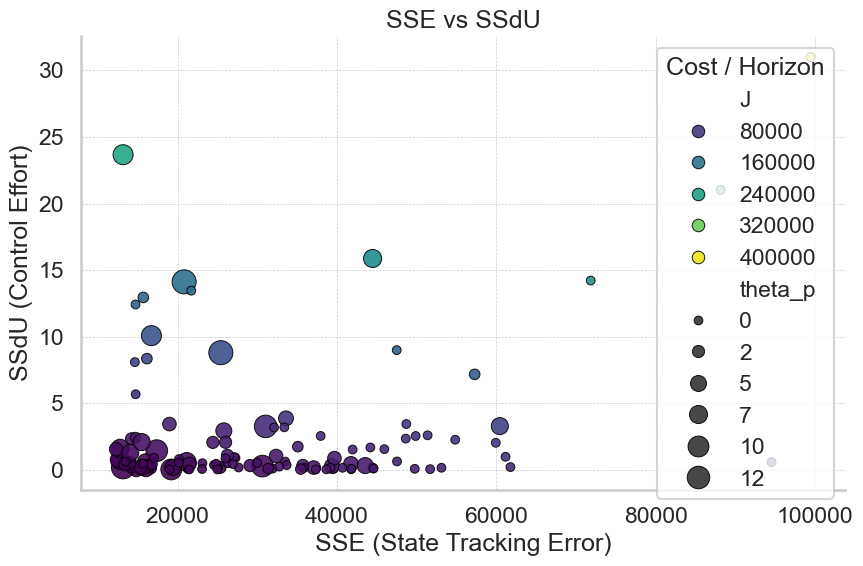

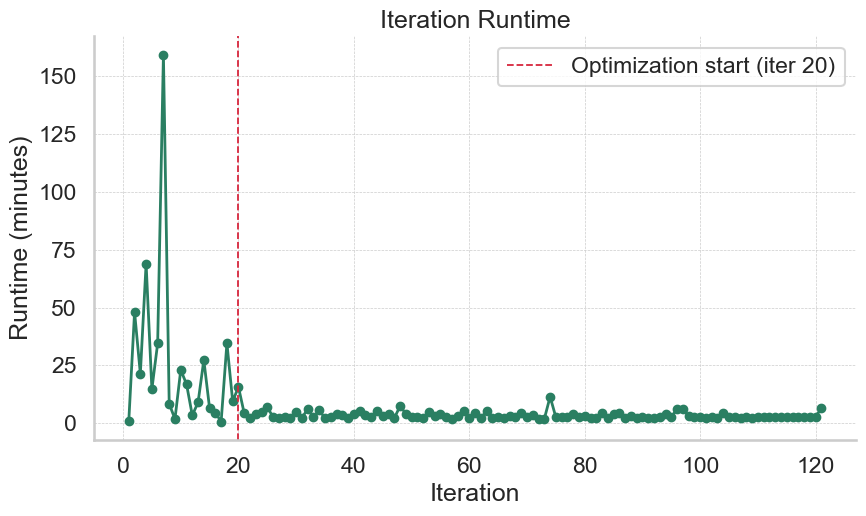

Saved SSE vs SSdU scatter plot to results\sse_vs_ssdu.png
Saved runtime vs iteration plot to results\runtime_vs_iteration.png


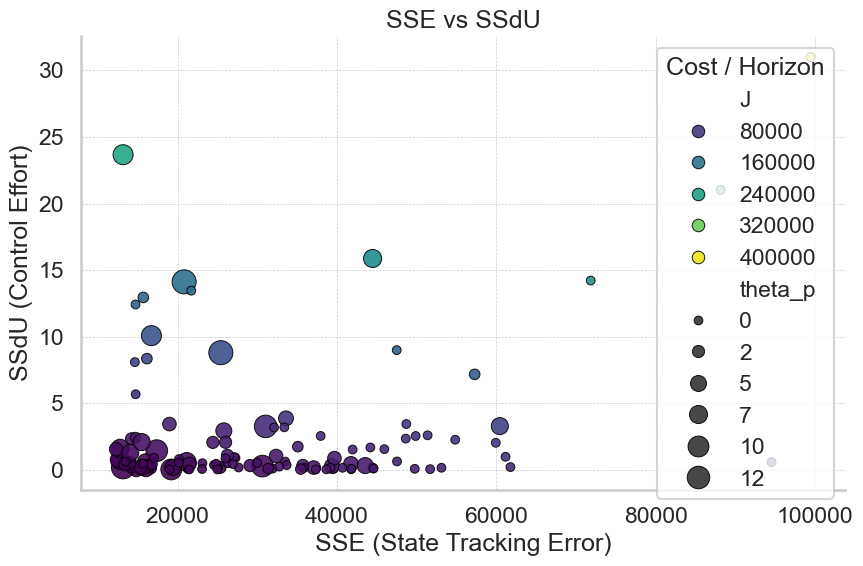

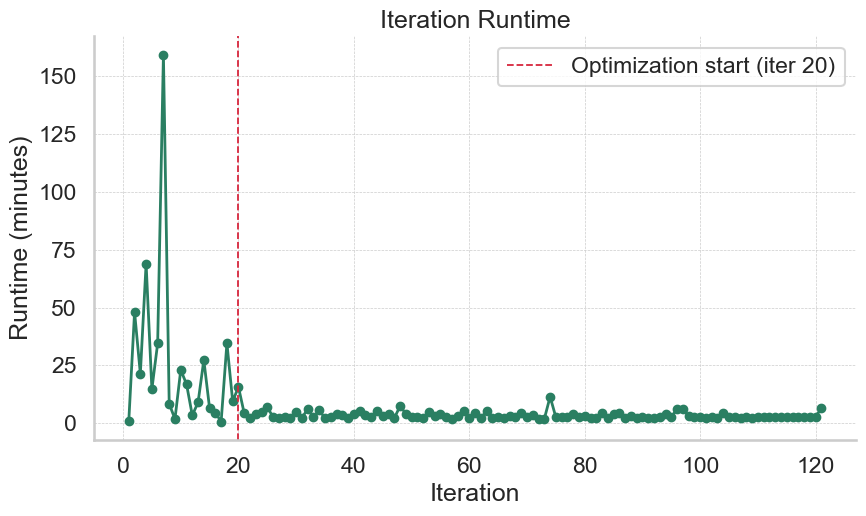

In [5]:
sse_fig, _ = plot_sse_vs_ssdu(df)
runtime_fig, _ = plot_runtime_vs_iteration(df)

DEFAULT_PLOT_PATH.parent.mkdir(parents=True, exist_ok=True)
RUNTIME_PLOT_PATH.parent.mkdir(parents=True, exist_ok=True)
sse_fig.savefig(DEFAULT_PLOT_PATH, dpi=300, bbox_inches="tight")
runtime_fig.savefig(RUNTIME_PLOT_PATH, dpi=300, bbox_inches="tight")

display(sse_fig)
display(runtime_fig)

print(f"Saved SSE vs SSdU scatter plot to {DEFAULT_PLOT_PATH}")
print(f"Saved runtime vs iteration plot to {RUNTIME_PLOT_PATH}")
